In [1]:
# =========================
# 1. Imports
# =========================
import re
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset
from collections import Counter
from tqdm import tqdm

# =========================
# 2. Load Dataset
# =========================
print("Loading dataset...")
ds = load_dataset("ai4bharat/samanantar", "mr")
data = ds["train"]

print("Total examples:", len(data))

# Convert small subset to pandas for faster EDA
N = 200_000  # change if needed
data = data.shuffle(seed=42).select(range(min(N, len(data))))
df = pd.DataFrame(data)

print("Subset size:", len(df))
print(df.head())

Loading dataset...


Generating train split:   0%|          | 0/3627480 [00:00<?, ? examples/s]

Total examples: 3627480
Subset size: 200000
       idx                                                src  \
0  1645745                              Political suggestions   
1  1617325                  He said this in a public meeting.   
2  2032197  Few close friends and family members attended ...   
3  2394991  Supreme Court closes a contempt plea filed by ...   
4    48024  The growth of our economy depends on PSBs abil...   

                                                 tgt  
0                            राजकीय पक्षांच्या सूचना  
1         यावेळी सभेत बोलताना त्यांनी ही घोषणा केली.  
2  तसेच त्यांच्या लग्नासोहळ्यासाठी काही नातेवाईक ...  
3  ‘चौकीदार चोर है’ या राहुल गांधी याच्या वक्तव्य...  
4  सार्वजनिक क्षेत्रातील बँकांची बाजारात वित्त पु...  


In [2]:
# Check missing values
print("\nMissing values:")
print(df.isnull().sum())

# Check empty strings
empty_src = (df["src"].str.strip() == "").sum()
empty_tgt = (df["tgt"].str.strip() == "").sum()

print("Empty src:", empty_src)
print("Empty tgt:", empty_tgt)


Missing values:
idx    0
src    0
tgt    0
dtype: int64
Empty src: 0
Empty tgt: 0


In [3]:
# Character lengths
df["src_char_len"] = df["src"].str.len()
df["tgt_char_len"] = df["tgt"].str.len()

# Token lengths (whitespace)
df["src_tok_len"] = df["src"].str.split().str.len()
df["tgt_tok_len"] = df["tgt"].str.split().str.len()

print("\nLength statistics (characters):")
print(df[["src_char_len", "tgt_char_len"]].describe())

print("\nLength statistics (tokens):")
print(df[["src_tok_len", "tgt_tok_len"]].describe())


Length statistics (characters):
        src_char_len   tgt_char_len
count  200000.000000  200000.000000
mean       65.875040      65.100285
std        54.492312      52.056455
min         5.000000       5.000000
25%        30.000000      33.000000
50%        49.000000      51.000000
75%        83.000000      81.000000
max      1280.000000    2579.000000

Length statistics (tokens):
        src_tok_len    tgt_tok_len
count  200000.00000  200000.000000
mean       11.25104       9.646345
std         8.84454       7.249315
min         1.00000       1.000000
25%         5.00000       5.000000
50%         9.00000       8.000000
75%        14.00000      12.000000
max       198.00000     340.000000


In [4]:
df["char_ratio"] = df["src_char_len"] / df["tgt_char_len"]
df["tok_ratio"] = df["src_tok_len"] / df["tgt_tok_len"]

print("\nRatio statistics (char ratio):")
print(df["char_ratio"].describe())

print("\nHighly suspicious pairs (ratio > 3 or < 0.33):")
bad_ratio = df[(df["char_ratio"] > 3) | (df["char_ratio"] < 0.33)]
print("Count:", len(bad_ratio))


Ratio statistics (char ratio):
count    200000.000000
mean          1.029113
std           0.380379
min           0.083045
25%           0.803571
50%           0.970588
75%           1.170732
max          12.285714
Name: char_ratio, dtype: float64

Highly suspicious pairs (ratio > 3 or < 0.33):
Count: 1037


In [5]:
dup_pairs = df.duplicated(subset=["src", "tgt"]).sum()
print("\nDuplicate pairs:", dup_pairs)

dup_src = df.duplicated(subset=["src"]).sum()
dup_tgt = df.duplicated(subset=["tgt"]).sum()

print("Duplicate src:", dup_src)
print("Duplicate tgt:", dup_tgt)


Duplicate pairs: 0
Duplicate src: 18049
Duplicate tgt: 338


In [6]:
def contains_devanagari(text):
    return bool(re.search(r'[\u0900-\u097F]', text))

df["mr_has_devanagari"] = df["tgt"].apply(contains_devanagari)

print("\nMarathi lines without Devanagari script:",
      (~df["mr_has_devanagari"]).sum())


Marathi lines without Devanagari script: 0


In [7]:
# Rough token vocab estimate (whitespace-based)
src_vocab = Counter()
tgt_vocab = Counter()

for s in df["src"]:
    src_vocab.update(s.split())

for s in df["tgt"]:
    tgt_vocab.update(s.split())

print("\nEstimated vocab size (whitespace):")
print("English:", len(src_vocab))
print("Marathi:", len(tgt_vocab))


Estimated vocab size (whitespace):
English: 123511
Marathi: 200417


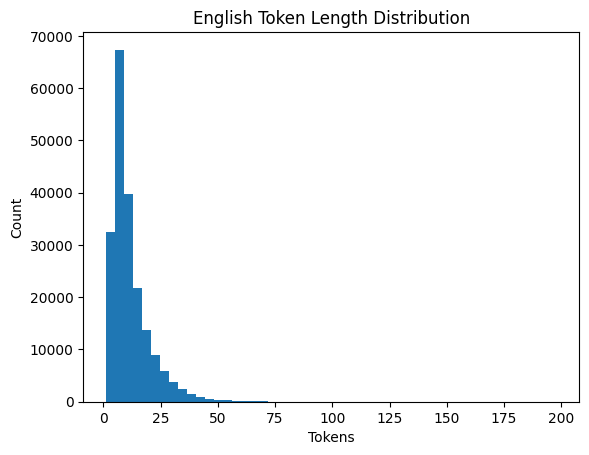

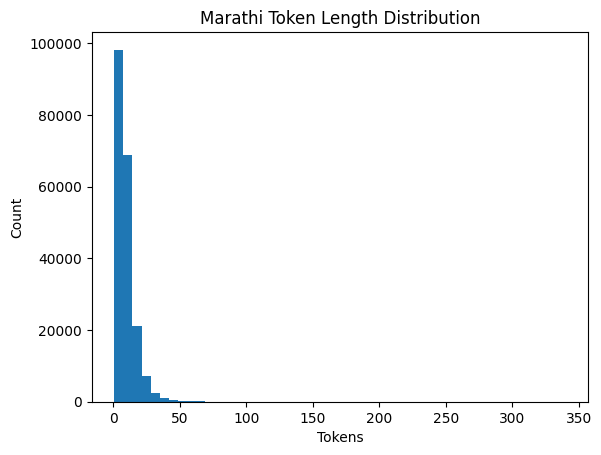

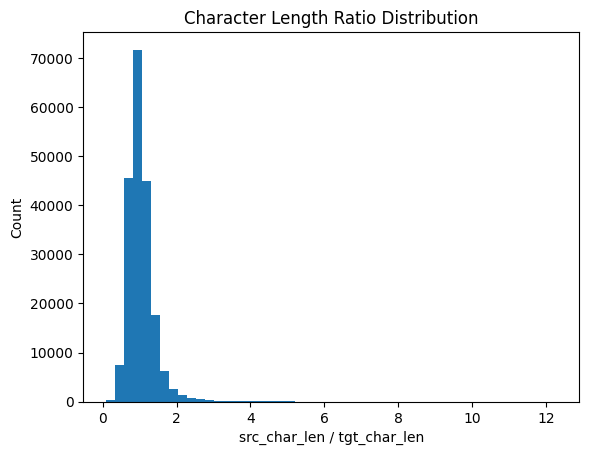

In [8]:
plt.figure()
plt.hist(df["src_tok_len"], bins=50)
plt.title("English Token Length Distribution")
plt.xlabel("Tokens")
plt.ylabel("Count")
plt.show()

plt.figure()
plt.hist(df["tgt_tok_len"], bins=50)
plt.title("Marathi Token Length Distribution")
plt.xlabel("Tokens")
plt.ylabel("Count")
plt.show()

plt.figure()
plt.hist(df["char_ratio"], bins=50)
plt.title("Character Length Ratio Distribution")
plt.xlabel("src_char_len / tgt_char_len")
plt.ylabel("Count")
plt.show()

In [9]:
print("\nRandom sample pairs:\n")
for i in random.sample(range(len(df)), 10):
    print("EN:", df.iloc[i]["src"])
    print("MR:", df.iloc[i]["tgt"])
    print("-" * 60)


Random sample pairs:

EN: These included: murder, kidnapping, arson and assault.
MR: यामध्ये खूनाचा प्रयत्न, जबरी चोरी, दंगल, मारामारी यासारख्या गुन्ह्यांचा समावेश आहे.
------------------------------------------------------------
EN: Film trade analyst Taran Adarsh took to Twitter to make the announcement.
MR: चित्रपट व्यापार विश्लेषक तरण आदर्श यांनी माहिती दिली आहे
------------------------------------------------------------
EN: This plant will sprout on old wood.
MR: ह्या कुळातील सदाहरित वृक्ष वर्षावनांत फोफावतात.
------------------------------------------------------------
EN: Remote desktop sharing password
MR: रिमोट डेस्कटॉप शेअरिंग पासवर्ड
------------------------------------------------------------
EN: His father used to work in a private company.
MR: वडिलांना एका खासगी कंपनीत बऱ्यापैकी नोकरी.
------------------------------------------------------------
EN: I do not know how people will perceive this statement.
MR: मला माहीत नाही की लोक माझ्या विधानाचा काय अर्थ काढतील.
--------

In [10]:
filtered = df[
    (df["src_char_len"] > 2) &
    (df["tgt_char_len"] > 2) &
    (df["char_ratio"] < 2.8) &
    (df["char_ratio"] > 0.35) &
    (df["src_tok_len"] < 80) &
    (df["tgt_tok_len"] < 80) &
    (df["mr_has_devanagari"])
]

print("\nAfter filtering:", len(filtered))
print("Retention %:", len(filtered) / len(df) * 100)


After filtering: 198409
Retention %: 99.2045


In [21]:
# Remove duplicate English
df = df.drop_duplicates(subset=["src"])

# Strong but safe filtering
df = df[
    (df["src_char_len"] > 5) &
    (df["tgt_char_len"] > 5) &
    (df["char_ratio"] < 2.5) &
    (df["char_ratio"] > 0.4) &
    (df["src_tok_len"] < 60) &
    (df["tgt_tok_len"] < 60) &
    (df["mr_has_devanagari"])
].reset_index(drop=True)

print("Final dataset size:", len(df))

Final dataset size: 179054


In [22]:
df[['src','tgt']].to_csv('samantar_dataset.csv',index=False)